# Grundläggande analys och statistik

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

In [ ]:
# Läsning av datasetet
df = pd.read_csv("../data/health_study_dataset.csv")

# Snabb kontroll
print(df.sample(5))
print()
print(df.info())
print()
print(df.describe())

In [ ]:
# Städning
df.isna().sum()
df.duplicated().sum()

summary = """
Inledande observation

- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden
"""

print(summary)

## Beskrivande analys

In [ ]:
# Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
desc_stat = df[["age","weight","height","systolic_bp","cholesterol"]].agg(["mean", "median", "min", "max"])
print(desc_stat)

In [ ]:
# Histogram: åldersfördelning efter kön
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle("Understanding sample population", fontsize=17)

for s, subset in df.groupby("sex"):
    ax1.hist(subset["age"], edgecolor="#777777", bins=20, label=f"{s}", alpha=0.4)
ax1.set_title("Age distribution per gender")
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequence")
ax1.legend()

# Stapeldiagram: andel rökare
smoker_per = (df["smoker"].value_counts() / df["smoker"].count()) * 100

ax2.bar(smoker_per.index, smoker_per.values, 
        color="#FBC15E", width=0.7, alpha=0.7)
ax2.set_title("Non-Smokers vs Smokers")
ax2.set_xlabel("Smokers")
ax2.set_ylabel("%")
for i, v in enumerate(smoker_per.values):
    ax2.text(i, v + 1, f"{v:.1f}%", ha="center")
plt.tight_layout()
fig1.savefig("../img/fig1")
plt.show()

# Histogram: BMIfördelning
fig2, (ax3, ax4) = plt.subplots(1, 2)
fig2.suptitle("Checking health metrics", fontsize=17)

df["bmi"] = df["weight"] / (df["height"] / 100)**2
ax3.hist(df["bmi"], color="#8EBA42", edgecolor="#777777", bins=20, alpha=0.7)
ax3.set_title("BMI distribution")
ax3.set_xlabel("BMI")
ax3.set_ylabel("Frequency")

# Boxplot: cholesterol efter gender
ax4.boxplot([df.loc[df.sex == "F", "cholesterol"], 
           df.loc[df.sex == "M", "cholesterol"]], 
           tick_labels=["Female", "Male"], 
           showmeans=True)
ax4.set_title("Cholesterol distribution per gender")
ax4.set_xlabel("Gender")
ax4.set_ylabel("Cholesterol level")
plt.tight_layout()
fig2.savefig("../img/fig2")
plt.show()

# Scatter: age vs cholesterol
fig3, (ax5, ax6) = plt.subplots(1, 2)
fig3.suptitle("Exploring relationships", fontsize=17)

ax5.scatter(df["age"], df["cholesterol"], color="#988ED5", edgecolor="#777777", alpha=0.4)
ax5.set_title("Age vs Cholesterol")
ax5.set_xlabel("Age")
ax5.set_ylabel("Cholesterol level")

# Boxplot: systoliskt blodtryck efter grupp med/utan sjukdom
ax6.boxplot([df.loc[df.disease == 1, "systolic_bp"], 
           df.loc[df.disease == 0, "systolic_bp"]], 
           tick_labels=["Disease", "No disease"], 
           showmeans=True)
ax6.set_title("Systolic bp distribution")
ax6.set_xlabel("Group type")
ax6.set_ylabel("Systolic blood pressure")
plt.tight_layout()
fig3.savefig("../img/fig3")
plt.show()

summary2 = """
Insights:
1. Män och kvinnor är ganska jämnt representerade över åldersspektrumet och förekomsten av rökare är låg.
2. Normal viktintervall med få extremvärden. Liknande kolesterolnivåer mellan kvinnor och män.
3. Scatter-diagrammet visar att kolesterolnivån tenderar att öka med åldern. 
4. Det systoliska blodtrycket är liknande mellan grupper med eller utan sjukdom, vilket tyder på att det systoliska blodtrycket ensam inte kan indikera en grupp med eller utan sjukdom.
"""
print(summary2)

## Simulering kopplad till caset

In [ ]:
np.random.seed(42) 

p_disease = df["disease"].mean()

# Simulering av 1000 slumpmässiga individer med samma sjukdomsandel
simulated_1000_people = np.random.choice([0, 1], size=1000, p=[1 - p_disease, p_disease])

# Räkna andelen personer med sjukdom i simulering
simulated_p_disease = simulated_1000_people.mean()

# Jämförelse
summary3 = f"""
Verklig sjukdomsfrekvens: {p_disease * 100:.2f}%.
Simulerad sjukdomsfrekvens: {simulated_p_disease * 100:.2f}%

Slutsats:
Skillnaden mellan den verkliga sjukdomsfrekvensen och den simulerade sjukdomsfrekvensen är liten 
och ligger inom den förväntade variationen.
"""
print(summary3)

## Konfidensintervall

In [ ]:
systolic_bp = np.array(df["systolic_bp"], dtype=float)
confidence = 0.95
m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)
n = len(systolic_bp)
z = 1.96

# Normalapproximation
margin_error = z * (s / np.sqrt(n))
lo = m - margin_error
hi = m + margin_error

# Bootstrap
B = 3000
boot_means = np.empty(B)
for b in range(B):
    boot_sample = np.random.choice(systolic_bp, size=n, replace=True)
    boot_means[b] = np.mean(boot_sample)

alpha = (1 - confidence) / 2
bmean = np.mean(boot_means)
blo, bhi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])

summary4 = f"""
Punktuppskattning: {m:.2f}
Standardavvikelse: {s:.2f}

Resultatet av normalapproximationen är:
Nedre 95% CI-gräns: {lo:.2f}
Övre 95% CI-gräns: {hi:.2f}

Resultatet från bootstrap är:
Medelvärde för statistiken: {bmean:.2f}
Nedre 95% CI-gräns: {blo:.2f}
Övre 95% CI-gräns: {bhi:.2f}

Slutsats:
Båda metoderna gav ett mycket liknande resultat.
"""
print(summary4)

In [ ]:
# Error bar: jämförelse mellan konfidensintervall beräknat med normalapproximation och med bootstrap
fig4, ax = plt.subplots(figsize=(5,5))
ax.errorbar(x=0, y=m, yerr=margin_error, fmt="o", label="Normal Approximation", capsize=5)
ax.errorbar(x=1, y=bmean, yerr=[[bmean-blo], [bhi-bmean]], fmt="o", label="Bootstrap", capsize=5)
ax.set_xticks([0,1])
ax.set_xticklabels(["Normal Approximation", "Bootstrap"])
ax.set_ylabel("Systolic BP")
ax.set_title("95% Confidence Intervals for systolic BP")
ax.legend()
fig1.savefig("../img/fig4 error bar")
plt.show()

## Hypotesprövning

**Hypoteser**:  
H0: Rökare och icke-rökare har samma blodtryck  
H1: Rökare har högre blodtryck än icke-rökare

In [ ]:
smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

# 2 indipendent samples, one-sided test (right tail)
t_stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False, alternative="greater")
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
diff_means = smokers_mean - non_smokers_mean

summary5 = f"""
Medelvärde rökare: {smokers_mean:.3f}
Medelvärde icke-rökare: {non_smokers_mean:.3f}
Skillnad mellan medelvärdena: {diff_means:.3f}

Testet gav ett t-värde på {t_stat:.3f} och ett p-värde på {p_value:.3f}.
"""
print(summary5)

**Motivering och val av test**:  
Att undersöka om det finns en signifikant skillnad i medelvärdet av systoliskt blodtryck mellan rökare och icke-rökare.

Val av test: Tvåprovstest (Welch’s t-test)
- Data är kvantitativa och de två grupperna är oberoende.
- Welch’s t-test är lämpligt eftersom grupperna har olika storlek.
- Ensidigt test (höger svans) används eftersom vi specifikt vill testa om rökare har högre blodtryck.
- Signifikansnivå α = 0,05, vilket är standard.

**Tolkning**:
Eftersom p-värdet är större än 0,05 kan vi inte förkasta H0. Det finns inte tillräcklig evidens för att dra slutsatsen att rökare har högre blodtryck än icke-rökare.

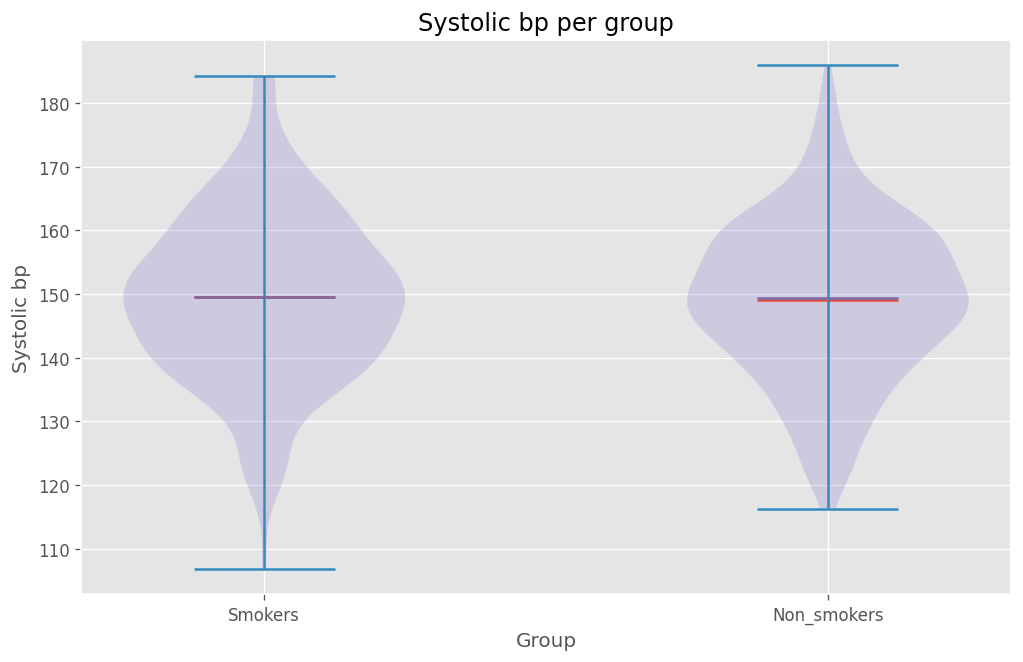

In [43]:
# Violin plot: systoliskt blodtryck efter grupp rökare/icke rökare
data = [smokers, non_smokers]

fig5, ax = plt.subplots()
vp = ax.violinplot(data, showmeans=True, showmedians=True)
for body in vp["bodies"]:
    body.set_facecolor("#988ED5")
vp["cmedians"].set_color("#7A68A6")
vp["cbars"].set_color("#348ABD")
vp["cmaxes"].set_color("#348ABD")
vp["cmins"].set_color("#348ABD")
ax.set_title("Systolic bp per group")
ax.set_xlabel("Group")
ax.set_ylabel("Systolic bp")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Smokers", "Non_smokers"])
fig5.savefig("../img/fig5 violin plot")
plt.show()

## Simulering av statistisk power

In [ ]:
# Matematisk beräkning av statistisk power 
alpha = 0.05
n_smokers, n_non_smokers = len(smokers), len(non_smokers)
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
ratio = n_non_smokers / n_smokers

sd_smokers, sd_non_smokers = smokers.std(), non_smokers.std()
pooled_sd = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

effect_size = (smokers_mean - non_smokers_mean) / pooled_sd

solver = TTestIndPower()
theoretical_power = solver.power(effect_size=effect_size, nobs1=n_smokers, ratio=ratio, alpha=alpha, alternative="larger")

# Beräkning av statistisk power genom simulering
def simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=0.05, n_sim=5000):
    rejections = 0
    for _ in range(n_sim):
        smokers = np.random.normal(smokers_mean, sd_smokers, n_smokers)
        nonsmokers = np.random.normal(non_smokers_mean, sd_non_smokers, n_non_smokers)
        
        t_stat_sim, p_val = stats.ttest_ind(smokers, nonsmokers, equal_var=False, alternative="greater")
        
        if p_val < alpha:
            rejections += 1

    return rejections / n_sim

sim_power = simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=alpha, n_sim=20000)

summary6= f"""
Testets styrka
Effektstorlek: {effect_size:.3f}
Teoretisk power: {theoretical_power:.3f}
Simulerad power: {sim_power:.3f}
"""
print(summary6)

In [ ]:
# Poweranalys 
power_target = 0.8
ratio = n_non_smokers / n_smokers

# Use the pooled SD
s_pooled = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

# Initialize solver
solver = TTestIndPower()

# Solve for Cohen's d needed to reach 80% power
required_d = solver.solve_power(effect_size=None, nobs1=n_smokers, ratio=ratio, alpha=alpha, power=power_target, alternative="larger")

required_mean_diff = required_d * s_pooled

summary7 = f"""
För att uppnå 80% power skulle testet kräva en medelvärdesskillnad på cirka {required_mean_diff:.2f} mmHg (Cohen’s d ≈ {required_d:.2f}). 
Den observerade skillnaden (≈ {diff_means:.2f} mmHg) är mycket mindre, vilket förklarar den låga styrkan ({sim_power * 100}%). 
"""
print(summary7)

**Motivering och resultat**:  

Syftet är att uppskatta när testet är tillräckligt känsligt för att upptäcka en verklig effekt. Både teoretisk och simulerad styrka beräknades för att jämföra resultaten och kontrollera att simuleringen stämmer med de teoretiska förväntningarna.

Simuleringen visar att den statistiska styrkan är mycket låg (~0,1). Detta beror på att den observerade skillnaden i medelvärde (≈ 0,47 mmHg) är liten jämfört med variationen inom grupperna (SD ≈ 13 mmHg). Resultatet tyder på att det icke-signifikanta testet reflekterar en verklig brist på meningsfull skillnad.

En effektstyrkeanalys visar dessutom att för att uppnå 80% styrka skulle en skillnad på ≈ 2,55 mmHg krävas, betydligt större än den observerade. Detta bekräftar att testets låga styrka är förenlig med den lilla effekt som hittats.

**Tolkning**:
I praktiken bekräftar testet att rökstatus inte är förknippad med någon kliniskt eller statistiskt signifikant förändring av blodtrycket i detta urval.

**Källor**:  
Scipy-dokumentation angående ttest_ind:  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html [12/11/2025]

Dokumentation från w3cub och statsmodels angående solve_power:  
- https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.power.ttestindpower.solve_power [12/11/2025]  
- https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.solve_power.html#statsmodels.stats.power.TTestPower.solve_power [12/11/2025]